# Categorizing images of breast cancer with CNNs (convolutional neural networks)

The project will follow the structure :

### 0. Data resume, goal definition and guideline
### 1. Importing the needed libraries and setting up the randomness
### 2. Forming the database and getting familiar with it
### 3. Data preprocessing and splitting
### 4. Building, tuning and training models
#### 4.1 Experiment 1: Try different number of layers and pooling chains to reach certain image sizes
#### 4.2 Experiment 2: Tweak the number of kernels in convolutional layers
#### 4.3 Experiment 3: Increase / decrease dropout rate
#### 4.4 Experiment 4: Increase / decrease the learning rate or decay of the best model
### 5. Final analysis


## 0. Data resume, goal definition and guideline

The whole dataset is comprised of <b>277 524</b> colored images, sized <b>50x50</b> pixels, showing normal and cancerous breast tissue. They are derived from bigger images, so when it comes to looking for problematic cells, the border of the image may also include important information. The cancer is abbreviated as IDC - Invasive Ductal Carcinoma. Almost a quater of the images contain the cancerous cells - <b>78 786</b> images, whereas <b>198 738</b> images show non-cancerous tissue. This makes the dataset imbalanced.

The dataset is taken from <b>[Kaggle]</b>(https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images).

The project is influenced by https://www.kaggle.com/code/sitinursarah/deep-learning-classification-on-breast-cancer/notebook#Analysis.

The goal is to build a classifier that could seperate the images into two groups (cancerous and non-cancerous) with high accuracy (incredibly important as the topic is healthcare). For this purpose a few seperate models using convolutional neural network will be built and trained. Their architecture will differ as there is no perfect model. Also not all images will be used, because:
- there's plenty of images, so the non-cancerous patches will be undersampled in order to achieve a better balance between classes. This is needed as lack of balance could give a false idea of accuracy.
- the data is a bit "heavy" - 1,5 GB.

When building the models, a few guidelines will be used :
1) A few <b><i>Convolutional layers</i></b>, each of which will have:
- <b>"same" padding</b> as the border of the image may contain parts of cancerous cells;
- small <b>kernel</b> = <b>3x3</b> or <b>5x5</b>, because it learns more quickly, compared to a larger one and simplifies the outcome, because less pixels affect the result. Given that the image will have padding, it would be better to use the smaller kernel - <b>3x3</b>, otherwise if the bigger (5x5) detects a cancerous cell on the border it would output more weight to it then a cancerous cell in the middle of the image;
- activation function <b>ReLU</b>, not only because of simplicity and speed, but also because it outperforms many other functions, when it comes to CNN;

2) A <b><i>Maxpooling layer</i></b>, right after a <b>convolutional layer</b>, as this strategy tends to give great results. It brings out the 'most important' pixels and gradually reduces the dimensionality of the filtered image, but its size should be small - perhaps a <b>2x2</b> so there won't be a lot of information missing for the next layer. In order to get rid of overlap during pooling, the stride needs to have the same value = 2. However if a bigger pooling size is chosen, an overlap would be a wise choice;

3) A <b><i>Flatten layer</i></b> - to ensure the data is ready to be fed to <b>Dense layer</b>.

4) A few <b><i>Dense layers</i></b> cascading in size, in order to reach the <b>output layer</b>. They might also be combined with a <b>Dropout layer</b>. The activation funciton will remain the same - <b>ReLU</b>, for reasons already mentioned.

5) A <b><i>Dropout layer</i></b> tends to give a network a little bit of 'plasticity' as it helps out with overfitting. It finds a place best between <b>Dense layers</b> and should not be used between <b>Convolutional layers</b> as it will delete info from a random pixel, which is counter intuitive. As always, small percentage of inactive neurons is more than enough and as the network 'bottles-down' less and less information should be lost;

6) An <b><i>Output layer</i></b>, comprised of 2 neurons, each making use of non-linear activation function, such as <b>Sigmoid</b> or <b>Softmax</b> to classify the image.

When it comes to training, the models should use : 
- for optimizer - <b><i>Adam</i></b> seems to be a great choice, as it outperforms many of its competitors;
- small <b><i>Learning Rate</i></b> which can be fixed, but may also be scheduled;
- <b>Binary cross entropy</b> for loss function (best for binary classification);
- <b>Accuracy</b> as metrics, since both positive and negative outcomes are important;

These ideas come not only from personal experience, but from successful model architectures used in the field of image classification. They reduce the choices to be made and allow to put more thought and time into experimenting with :
- number of filters used in a convolutional layer;
- pooling stride;
- dropout;
- learning rate;

Those can have a vast effect on the results.

## 1. Importing the needed libraries and setting up the randomness

In [77]:
%matplotlib inline

# Data Source and Paths
from os import listdir

# Utility Libraries
import numpy as np
import random
from PIL import Image

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

# Model architecture, optimizer and metrics
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

SEED = 42 # used for random shuffling

## 2. Forming the database and getting familiar with it

The images are separated into folders named after the patients' ID numbers and are categorized into 2 subfolders called "0" (for non-cancerous tissue) and "1" (for cancerous tissue). In order to get a more balanced dataset, lets get close to equal amounts of both classes from each patient.

In [2]:
main_folder = 'Breast_Cancer_Images-normal_or_IDC-50x50/' # path to the main folder containing all patients' images

folders = listdir(main_folder)

print("Total Number of Patients: "+ str(len(folders)))

Total Number of Patients: 279


The data is imbalanced, so in order to get it more balanced and to speed things up, you may choose the amount of images to get from each type, by setting values for the variables <b>"AMOUNT_CANCER"</b> and <b>"AMOUNT_NORMAL"</b>. The values should be integers in the range [5 000, 100 000]. It is adviced those values are close to each other, in order to get better results.

In [3]:
AMOUNT_CANCER = 15000
AMOUNT_NORMAL = 15000

if AMOUNT_CANCER < 5000:
    AMOUNT_CANCER = 5000
elif AMOUNT_CANCER > 78786:
    AMOUNT_CANCER = 78786
else:
    AMOUNT_CANCER = int(AMOUNT_CANCER)
    
print(f"You have decided to use {AMOUNT_CANCER} images of tissue with cancer to form the database.")

if AMOUNT_NORMAL < 5000:
    AMOUNT_NORMAL = 5000
elif AMOUNT_NORMAL > 100000:
    AMOUNT_NORMAL = 100000
else:
    AMOUNT_NORMAL = int(AMOUNT_NORMAL)

print(f"You have decided to use {AMOUNT_NORMAL} images of non-cancerous tissue to form the database.")

You have decided to use 15000 images of tissue with cancer to form the database.
You have decided to use 15000 images of non-cancerous tissue to form the database.


Lets form the database in the format : [image_path, category]

In [4]:
database = []

c_count = AMOUNT_CANCER # counter for images with cancer
n_count = AMOUNT_NORMAL # counter for images without cancer

for id in range(int(len(folders))):
    if(n_count + c_count == 0):
        break
        
    patient_id = folders[id]
    
    for category in [0,1]:
        if((category == 0 and n_count == 0) or (category == 1 and c_count == 0)):
            continue
    
        path = main_folder + patient_id + '/' + str(category) + '/'
        images = listdir(path)
        
        for image in images:
            if((category == 0 and n_count == 0) or (category == 1 and c_count == 0)):
                break
                
            image_path = path + image
            database.append([image_path, category])
            c_count = c_count - 1*(category == 1)
            n_count = n_count - 1*(category == 0)

print("Number of images in the database = " + str(len(database)))

print("Database info on each image is structured as follows :", database[0])

Number of images in the database = 30000
Database info on each image is structured as follows : ['Breast_Cancer_Images-normal_or_IDC-50x50/10253/0/10253_idx5_x1001_y1001_class0.png', 0]


Lets take a look at the first image in the database and see its dimensionality.

<b>Important :</b> representation of different color palattes may differ from the expected!

Image has dimensions = 50x50 pixels and 3 channels.


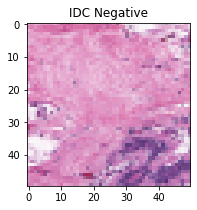

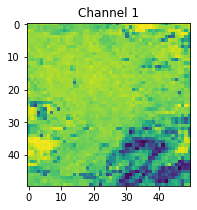

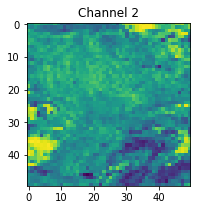

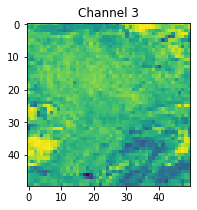

In [5]:
image_path = database[0][0]
category = database[0][1]

image = Image.open(image_path)
width, height = image.size

palettes = [x for x in image.split()]
channel_num = len(palettes)

print(f"Image has dimensions = {width}x{height} pixels and {channel_num} channels.")

plt.figure(figsize=(4, 3))
plt.imshow(image)

if category == 0:
    plt.title("IDC Negative")
else :
    plt.title("IDC Positive")

plt.show()

for i in range(channel_num):
    plt.figure(figsize=(4, 3))
    plt.imshow(palettes[i])
    plt.title(f"Channel {i + 1}")

Let seperate the data and labels in 2 groups and then get a sample to visualize :

In [6]:
Ndata = [image for image, label in database if label == 0]
Cdata = [image for image, label in database if label == 1]

Nlabels = [label for image, label in database if label == 0]
Clabels = [label for image, label in database if label == 1]

# Get a sample of images from each type of database
negativeSample = random.sample(Ndata, 50)
positiveSample = random.sample(Cdata, 50)

Lets get familiar with some of the images not containing cancerous tissue :

Text(0.5, 0.98, 'Non-cancerous tissue')

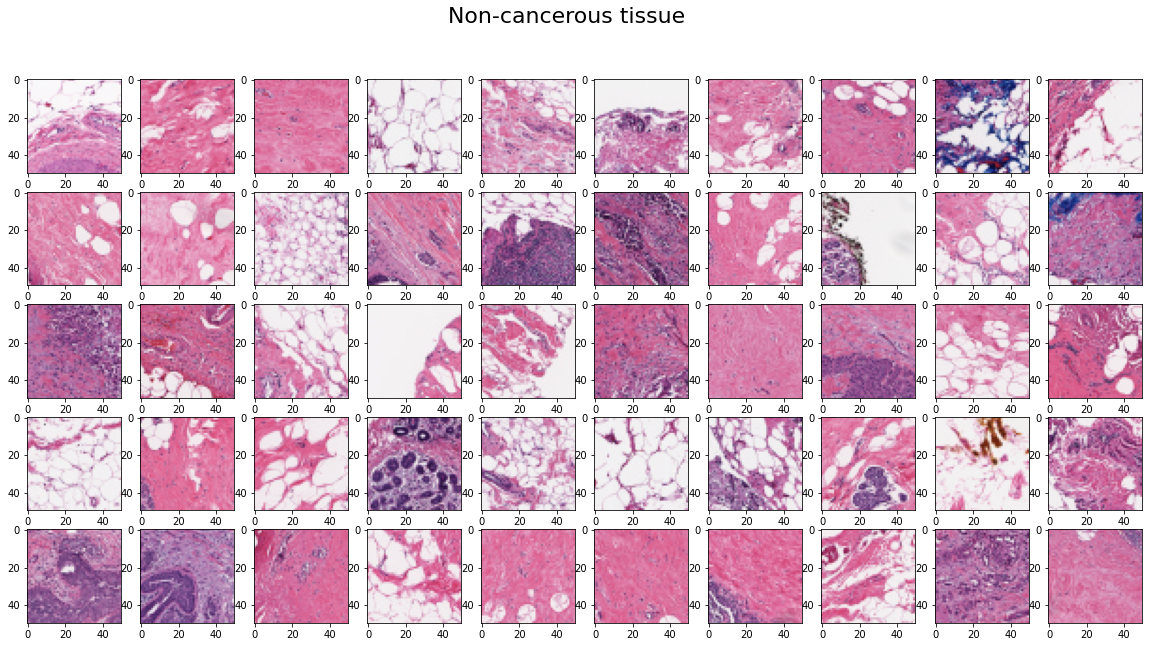

In [7]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = negativeSample[m + 10*n]
        image = Image.open(idx)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
fig.suptitle("Non-cancerous tissue", fontsize=22)

Lets get familiar with some of the images containing cancerous tissue :

Text(0.5, 0.98, 'Cancerous tissue')

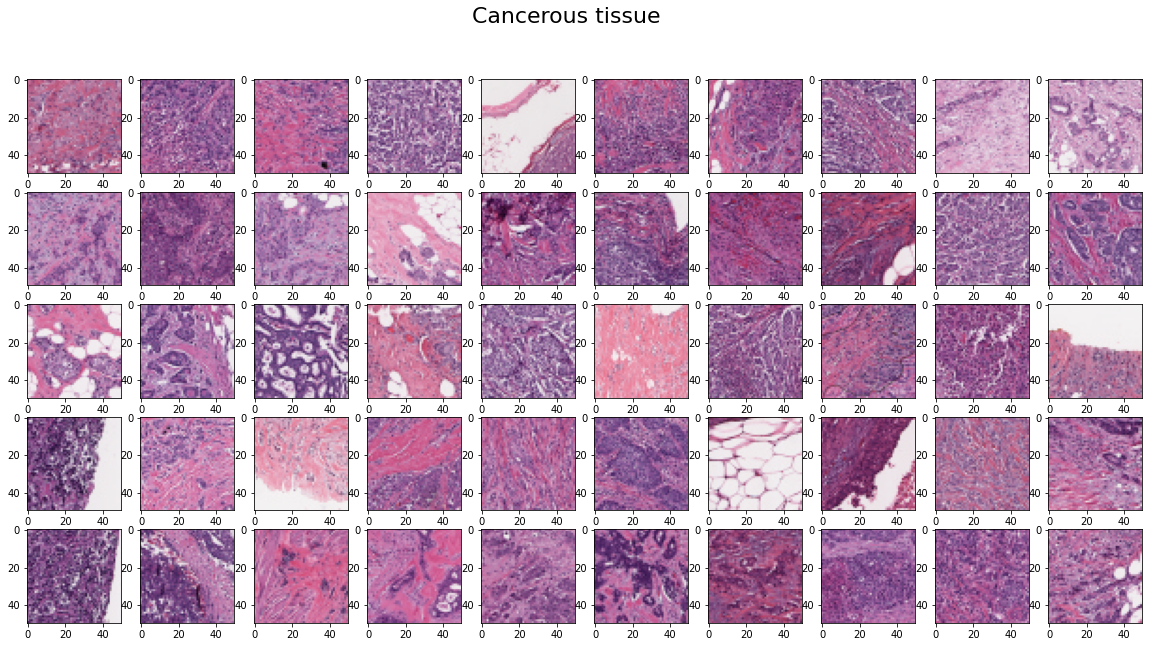

In [8]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = positiveSample[m + 10*n]
        image = Image.open(idx)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
fig.suptitle("Cancerous tissue", fontsize=22)

Lets see how balanced our data is.

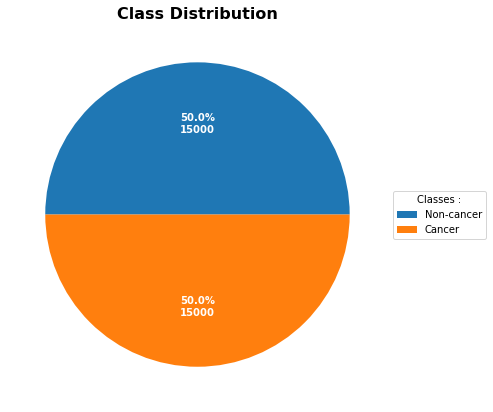

In [9]:
labels = ["Non-cancer", "Cancer"]
counts = [len(Ndata), len(Cdata)]

# A function to output both percentage and decimal value based on the category.
def portion_of_total(percent, total):
    decimal = int(np.round(percent/100.0*np.sum(total)))
    return f"{percent:.1f}%\n{decimal:d}"

fig, ax = plt.subplots(figsize=(14, 7), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(counts, autopct=lambda x: portion_of_total(x, counts), textprops=dict(color="w"))

ax.legend(wedges, labels,
          title="Classes :",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, weight="bold")

ax.set_title("Class Distribution", fontsize=16, weight="bold")

plt.show()

Perfectly balanced. The models should perform better that way.

## 3. Data preprocessing and splitting

Since the input is comprised of 3-channel 50x50 pixels images, which are catgorized with no missing labels, the only thing left to do is normalize the values in the images and then head to spliting and modeling. However, resizing the images to 50x50 would garantee that all the input has the required size.

Lets resize and normalize the input.

In [10]:
desired_size = (50,50)
resizedN = []
resizedC = []

for image_path in Ndata:
    image = Image.open(image_path)
    nimage = image.resize(desired_size, Image.LANCZOS) # LANCZOS should give the best result
    resizedN.append(nimage)
    
for image_path in Cdata:
    image = Image.open(image_path)
    cimage = image.resize(desired_size, Image.LANCZOS) # LANCZOS should give the best result
    resizedC.append(cimage)
    
# Normalize the Dataset pixel values to [0, 1] range
Ndataset = np.array([np.array(image) / 255.0 for image in resizedN])
Cdataset = np.array([np.array(image) / 255.0 for image in resizedC])

# Shuffle the dataset
Ndataset = shuffle(Ndataset, random_state=SEED)
Cdataset = shuffle(Cdataset, random_state=SEED)

# Get the Shape of all dataset
print('Ndataset shape : {}' .format(Ndataset.shape))
print('Cdataset shape : {}' .format(Cdataset.shape))

Ndataset shape : (15000, 50, 50, 3)
Cdataset shape : (15000, 50, 50, 3)


In [11]:
# Split the data

# Split each dataset into training data and temporary data - 70:30

Ntrain, Ntemp, Ntrain_labels, Ntemp_labels = train_test_split(Ndataset, Nlabels, test_size=0.3, stratify=Nlabels, random_state=SEED)
Ctrain, Ctemp, Ctrain_labels, Ctemp_labels = train_test_split(Cdataset, Clabels, test_size=0.3, stratify=Clabels, random_state=SEED)

# Use the temporary data to split into Validation and Testing Data - 50:50
Nval, Ntest, Nval_labels, Ntest_labels = train_test_split(Ntemp, Ntemp_labels, test_size=0.5, stratify=Ntemp_labels, random_state=SEED)
Cval, Ctest, Cval_labels, Ctest_labels = train_test_split(Ctemp, Ctemp_labels, test_size=0.5, stratify=Ctemp_labels, random_state=SEED)

# Combine the two Non-cancer datasets and the Cancer dataset to make one train_data, val_data, test_data
train_data = np.concatenate((Ntrain, Ctrain), axis=0)
val_data   = np.concatenate((Nval  , Cval)  , axis=0)
test_data  = np.concatenate((Ntest , Ctest) , axis=0)

train_labels = np.concatenate((Ntrain_labels, Ctrain_labels), axis=0)
val_labels   = np.concatenate((Nval_labels  , Cval_labels)  , axis=0)
test_labels  = np.concatenate((Ntest_labels , Ctest_labels) , axis=0)

# Shuffle the datasets
train_data = shuffle(train_data, random_state=SEED)
val_data   = shuffle(val_data,   random_state=SEED)
test_data  = shuffle(test_data,  random_state=SEED)

train_labels = shuffle(train_labels, random_state=SEED)
val_labels   = shuffle(val_labels,   random_state=SEED)
test_labels  = shuffle(test_labels,  random_state=SEED)

# Reformat the shape for the labels
train_labels = to_categorical(train_labels, 2)
val_labels   = to_categorical(val_labels, 2)
test_labels  = to_categorical(test_labels, 2)
print('train_data shape : {}'   .format(train_data.shape))
print('train_labels shape : {}' .format(train_labels.shape))
print('val_data shape : {}'     .format(val_data.shape))
print('val_labels shape : {}'   .format(val_labels.shape))
print('test_data shape : {}'    .format(test_data.shape))
print('test_labels shape : {}'  .format(test_labels.shape))

train_data shape : (21000, 50, 50, 3)
train_labels shape : (21000, 2)
val_data shape : (4500, 50, 50, 3)
val_labels shape : (4500, 2)
test_data shape : (4500, 50, 50, 3)
test_labels shape : (4500, 2)


## 4. Building, tuning and training models

As stated in the begining there will be a few models built and trained. The one that behaves the best will be further optimized. The training process for all models will be the same in terms of number of <b>epochs</b> and size of <b>batches</b>.

<b>Architecture of the models :</b>

All models should have a few convolutional layers, each followed by a pooling layer. The convolutional layer will have the padding set to <b>"same"</b> as there might be important info on the border of the images which should not get lost or dampened. Given that the input images are small - 50x50 pixels, it makes sense to use small kernels - 3x3 for all layers. Its not self evident how many convolutional + pooling layers the network should have. Usually they are used until the resulting image gets "small enough" to have extracted some features (for example 2x2, 3x3, 4x4, 5x5, 6x6, etc.). It is very important for the behaviour of the model to have a nice and smooth size reduction, without information loss due to bad sizing of the output image. Since the convolutions will all make use of padding on each image, the image size reduction will come from the pooling. If all pooling layers use a 2x2 matrix, this would result in images sized : 50x50 -> 25x25 -> 12x12 -> 6x6. When we use pooling on 25x25 it would lead to 12x12 which would erase info, which may be important. Thus an overlapping pooling layer with 3x3 matrix and stride of 1 should be placed in the place of the first pooling layer. This will result in the following sequence of image dimensionality : 50x50 -> 48x48 -> 24x24 -> 12x12 (-> 6x6 (-> 3x3)). Another possibility is to have a chain like : 50x50 -> 48x48 -> 16x16 -> 8x8 (-> 4x4 (-> 2x2)).

When it comes to number of filters, lets have them start from 8 and double for each next convolutional layer. That way after each extraction, the channels grow, resulting in potentionally less important info being lost.

After the last pooling layer, a flattening of the output will take place. Afterwards the data will be fed into a few Dense + Dropout layers, leading to the output layer.

The dropout rate will start at 20% and get lower on each next layer.

All models will be optimized with the same learning rate = 0.001, which will decay by 98% per epoch.

<b>Experiment 1:</b> Try different number of layers and pooling chains to reach certain image sizes :
1) 50x50 -> 48x48 -> 24x24 -> 12x12 -> 6x6 -> 3x3

2) 50x50 -> 48x48 -> 24x24 -> 12x12 -> 6x6

3) 50x50 -> 48x48 -> 24x24 -> 12x12

3) 50x50 -> 48x48 -> 16x16 -> 8x8 -> 4x4 -> 2x2

4) 50x50 -> 48x48 -> 16x16 -> 8x8 -> 4x4

5) 50x50 -> 48x48 -> 16x16 -> 8x8

The best performing models will enter the next experiment.

<b>Experiment 2:</b> Tweak the number of kernels in convolutional layers.

<b>Experiment 3:</b> Increase / decrease dropout rate.

<b>Experiment 4:</b> Increase / decrease the learning rate or decay of the best model.

In [12]:
FILTERS = 8

To do all the experiments automatically a function is needed. In it each model will be :
1) assigned an optimizer with pre-set hyperparameters

2) get its training tracked

3) evaluated

4) get its training visualized

In [13]:
def train_evaluate_visualize(model, epochs=25, batch_size=100, initial_learning_rate=0.001, dacay_rate=0.98, use_early_stopping = False):
    # Set up the learning rate decay
    lr_schedule = ExponentialDecay(initial_learning_rate=initial_learning_rate, decay_steps=10000, decay_rate=dacay_rate)
    
    # Set up the optimizer
    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Track the progress of the training
    if use_early_stopping == True:
        early_stopping = EarlyStopping(
                                monitor='val_loss',        # Which metric to monitor
                                patience=5,                # Number of epochs without improvement to wait before stopping
                                restore_best_weights=True  # Restore model weights to the best epoch
                                )
            
        history = model.fit(train_data, train_labels, validation_data = (val_data, val_labels), epochs = epochs , batch_size = batch_size, callbacks=[early_stopping])
    else:
        history = model.fit(train_data, train_labels, validation_data = (val_data, val_labels), epochs = epochs , batch_size = batch_size)

    # Evaluate the trained model
    print()
    print("Lets check the accuracy on the testing dataset : ")
    model.evaluate(test_data,test_labels)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return history

After each experiment the model will be compared by accuracy and lost on both training and testing sets. For this repetitive action, a function will come in handy.

In [14]:
def plot_model_performance(histories, indexes):
    for x in ['accuracy', 'val_accuracy', 'loss', 'val_loss']:
        for h in histories:
            plt.plot(h.history[x])

        if 'accuracy' in x:
            if 'val' not in x:
                plt.title('Accuracy on training set')
            else:
                plt.title('Accuracy on testing set')

            plt.ylabel('accuracy')

        else:
            if 'val' not in x:
                plt.title('Loss on training set')
            else:
                plt.title('Loss on testing set')

            plt.ylabel('loss')

        plt.xlabel('epoch')

        plt.legend(['model_' + str(i) for i in indexes], loc='upper left')

        plt.show()

### 4.1 Experiment 1 : Try different number of layers and pooling chains to reach certain image sizes

Lets build the model mentioned in <b>1)</b> : 50x50 -> 48x48 -> 24x24 -> 12x12 -> 6x6 -> 3x3

In [15]:
f = FILTERS # base number of filters for this model
model_1 = Sequential([
                    Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                    MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),
    
                    Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_2'),
    
                    Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),
    
                    Conv2D(filters=8*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_4'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_4'),
    
                    Conv2D(filters=16*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_5'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_5'),
                    
                    Flatten(name='Flatten_layer'),
                    
                    Dense(128, activation='relu', name='Dense_1'),
                    Dropout(0.2, name='Dropout_1'),

                    Dense(32, activation='relu', name='Dense_2'),
                    Dropout(0.1, name='Dropout_2'),

                    Dense(8, activation='relu', name='Dense_3'),

                    Dense(2, activation='sigmoid', name='Output_layer')
                    ])

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 8)         224       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 8)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 16)        1168      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 24, 24, 16)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 24, 24, 32)        4640      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 12, 12, 32)        0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 12, 12, 64)        1

Lets build the model mentioned in <b>2)</b> : 50x50 -> 48x48 -> 24x24 -> 12x12 -> 6x6

In [16]:
f = FILTERS # base number of filters for this model
model_2 = Sequential([
                    Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                    MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),
    
                    Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_2'),
    
                    Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),
    
                    Conv2D(filters=8*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_4'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_4'),
                    
                    Flatten(name='Flatten_layer'),
    
                    Dense(128, activation='relu', name='Dense_1'),
                    Dropout(0.2, name='Dropout_1'),

                    Dense(32, activation='relu', name='Dense_2'),
                    Dropout(0.1, name='Dropout_2'),

                    Dense(8, activation='relu', name='Dense_3'),

                    Dense(2, activation='sigmoid', name='Output_layer')
                    ])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 8)         224       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 8)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 16)        1168      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 24, 24, 16)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 24, 24, 32)        4640      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 12, 12, 32)        0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 12, 12, 64)       

Lets build the model mentioned in <b>3)</b> : 50x50 -> 48x48 -> 24x24 -> 12x12

In [17]:
f = FILTERS # base number of filters for this model
model_3 = Sequential([
                    Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                    MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),
    
                    Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_2'),
    
                    Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),
                    
                    Flatten(name='Flatten_layer'),
    
                    Dense(128, activation='relu', name='Dense_1'),
                    Dropout(0.2, name='Dropout_1'),

                    Dense(32, activation='relu', name='Dense_2'),
                    Dropout(0.1, name='Dropout_2'),

                    Dense(8, activation='relu', name='Dense_3'),

                    Dense(2, activation='sigmoid', name='Output_layer')
                    ])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 8)         224       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 8)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 16)        1168      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 24, 24, 16)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 24, 24, 32)        4640      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 12, 12, 32)        0         
_________________________________________________________________
Flatten_layer (Flatten)      (None, 4608)             

Lets build the model mentioned in <b>4)</b> : 50x50 -> 48x48 -> 16x16 -> 8x8 -> 4x4 -> 2x2

In [18]:
f = FILTERS # base number of filters for this model
model_4 = Sequential([
                    Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                    MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),
    
                    Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                    MaxPooling2D(pool_size=(3, 3), strides=None, name='Pooling_2'),
    
                    Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),
    
                    Conv2D(filters=8*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_4'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_4'),
    
                    Conv2D(filters=16*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_5'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_5'),
                    
                    Flatten(name='Flatten_layer'),
    
                    Dense(128, activation='relu', name='Dense_1'),
                    Dropout(0.2, name='Dropout_1'),

                    Dense(32, activation='relu', name='Dense_2'),
                    Dropout(0.1, name='Dropout_2'),

                    Dense(8, activation='relu', name='Dense_3'),

                    Dense(2, activation='sigmoid', name='Output_layer')
                    ])

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 8)         224       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 8)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 16)        1168      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 16, 16, 16)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 16, 16, 32)        4640      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 8, 8, 32)          0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 8, 8, 64)         

Lets build the model mentioned in <b>5)</b> : 50x50 -> 48x48 -> 16x16 -> 8x8 -> 4x4

In [19]:
f = FILTERS # base number of filters for this model
model_5 = Sequential([
                    Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                    MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),
    
                    Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                    MaxPooling2D(pool_size=(3, 3), strides=None, name='Pooling_2'),
    
                    Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),
    
                    Conv2D(filters=8*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_4'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_4'),
                    
                    Flatten(name='Flatten_layer'),
    
                    Dense(128, activation='relu', name='Dense_1'),
                    Dropout(0.2, name='Dropout_1'),

                    Dense(32, activation='relu', name='Dense_2'),
                    Dropout(0.1, name='Dropout_2'),

                    Dense(8, activation='relu', name='Dense_3'),

                    Dense(2, activation='sigmoid', name='Output_layer')
                    ])

model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 8)         224       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 8)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 16)        1168      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 16, 16, 16)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 16, 16, 32)        4640      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 8, 8, 32)          0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 8, 8, 64)         

Lets build the model mentioned in <b>6)</b> : 50x50 -> 48x48 -> 16x16 -> 8x8

In [20]:
f = FILTERS # base number of filters for this model
model_6 = Sequential([
                    Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                    MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),
    
                    Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                    MaxPooling2D(pool_size=(3, 3), strides=None, name='Pooling_2'),
    
                    Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),
                    
                    Flatten(name='Flatten_layer'),
    
                    Dense(128, activation='relu', name='Dense_1'),
                    Dropout(0.2, name='Dropout_1'),

                    Dense(32, activation='relu', name='Dense_2'),
                    Dropout(0.1, name='Dropout_2'),

                    Dense(8, activation='relu', name='Dense_3'),

                    Dense(2, activation='sigmoid', name='Output_layer')
                    ])

model_6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 8)         224       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 8)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 16)        1168      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 16, 16, 16)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 16, 16, 32)        4640      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 8, 8, 32)          0         
_________________________________________________________________
Flatten_layer (Flatten)      (None, 2048)             

It seems that the third model has a lot less parameters to train, compared to the other two. Lets see how each behaves :

Train on 21000 samples, validate on 4500 samples
Epoch 1/25
21000/21000 [==============================] - 57s 3ms/sample - loss: 0.5434 - accuracy: 0.7076 - val_loss: 0.4632 - val_accuracy: 0.8146
Epoch 2/25
21000/21000 [==============================] - 18s 834us/sample - loss: 0.4469 - accuracy: 0.8070 - val_loss: 0.4303 - val_accuracy: 0.8171
Epoch 3/25
21000/21000 [==============================] - 17s 829us/sample - loss: 0.4216 - accuracy: 0.8169 - val_loss: 0.4293 - val_accuracy: 0.8103
Epoch 4/25
21000/21000 [==============================] - 17s 832us/sample - loss: 0.4092 - accuracy: 0.8233 - val_loss: 0.4022 - val_accuracy: 0.8370
Epoch 5/25
21000/21000 [==============================] - 17s 833us/sample - loss: 0.3983 - accuracy: 0.8306 - val_loss: 0.3897 - val_accuracy: 0.8304
Epoch 6/25
21000/21000 [==============================] - 17s 830us/sample - loss: 0.3931 - accuracy: 0.8306 - val_loss: 0.3699 - val_accuracy: 0.8473
Epoch 7/25
21000/21000 [=======================

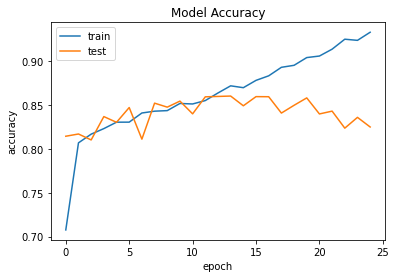

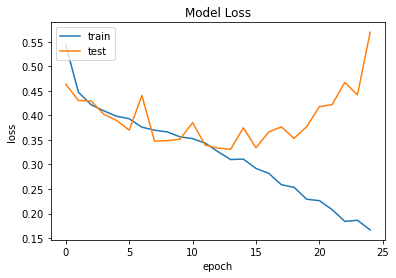

Train on 21000 samples, validate on 4500 samples
Epoch 1/25
21000/21000 [==============================] - 17s 805us/sample - loss: 0.5110 - accuracy: 0.7509 - val_loss: 0.4764 - val_accuracy: 0.7818
Epoch 2/25
21000/21000 [==============================] - 16s 768us/sample - loss: 0.4507 - accuracy: 0.8043 - val_loss: 0.4185 - val_accuracy: 0.8236
Epoch 3/25
21000/21000 [==============================] - 16s 769us/sample - loss: 0.4255 - accuracy: 0.8188 - val_loss: 0.3917 - val_accuracy: 0.8364
Epoch 4/25
21000/21000 [==============================] - 16s 769us/sample - loss: 0.4087 - accuracy: 0.8255 - val_loss: 0.3743 - val_accuracy: 0.8431
Epoch 5/25
21000/21000 [==============================] - 16s 769us/sample - loss: 0.3860 - accuracy: 0.8390 - val_loss: 0.3695 - val_accuracy: 0.8477
Epoch 6/25
21000/21000 [==============================] - 16s 767us/sample - loss: 0.3823 - accuracy: 0.8389 - val_loss: 0.3649 - val_accuracy: 0.8476
Epoch 7/25
21000/21000 [=====================

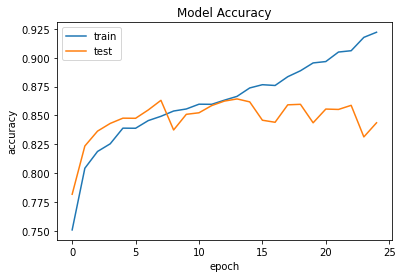

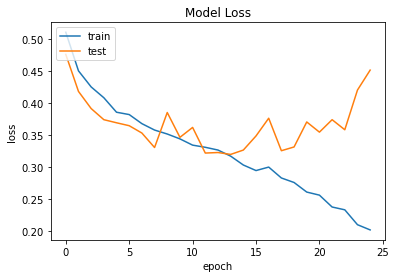

Train on 21000 samples, validate on 4500 samples
Epoch 1/25
21000/21000 [==============================] - 16s 750us/sample - loss: 0.5216 - accuracy: 0.7446 - val_loss: 0.4669 - val_accuracy: 0.7981
Epoch 2/25
21000/21000 [==============================] - 15s 714us/sample - loss: 0.4516 - accuracy: 0.8040 - val_loss: 0.4367 - val_accuracy: 0.8004
Epoch 3/25
21000/21000 [==============================] - 15s 714us/sample - loss: 0.4283 - accuracy: 0.8150 - val_loss: 0.4173 - val_accuracy: 0.8133
Epoch 4/25
21000/21000 [==============================] - 15s 715us/sample - loss: 0.4127 - accuracy: 0.8233 - val_loss: 0.3832 - val_accuracy: 0.8326
Epoch 5/25
21000/21000 [==============================] - 15s 714us/sample - loss: 0.3996 - accuracy: 0.8295 - val_loss: 0.4139 - val_accuracy: 0.8068
Epoch 6/25
21000/21000 [==============================] - 15s 714us/sample - loss: 0.3813 - accuracy: 0.8383 - val_loss: 0.3777 - val_accuracy: 0.8339
Epoch 7/25
21000/21000 [=====================

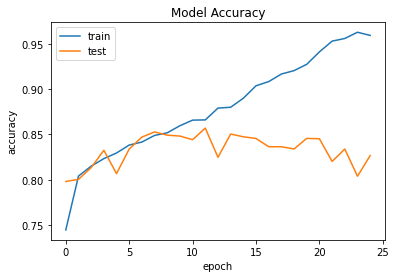

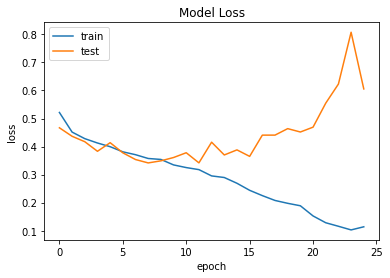

In [21]:
history_1 = train_evaluate_visualize(model_1)
history_2 = train_evaluate_visualize(model_2)
history_3 = train_evaluate_visualize(model_3)

While <b>model_1</b> (last 'image' layer is 3x3) and <b>model_2</b> (last 'image' layer is 6x6) start overfitting at about 12th-13th epoch, <b>model_3</b> (last 'image' layer is 12x12) starts much earlier - at about 8th epoch. The peak performance of all models over the validation data is at about 85% accuracy. It seems that <b>model_2</b> has the best performance as it accuracy on the testing data is 84,5%. Lets have a comparative look :

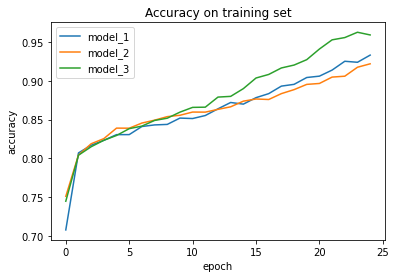

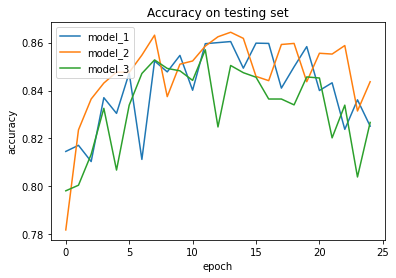

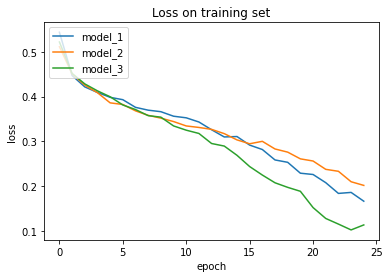

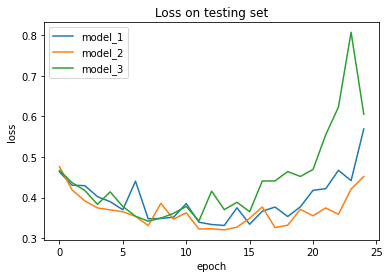

In [22]:
plot_model_performance( [history_1, history_2, history_3], [1, 2, 3] )

Clearly <b>model_2</b> has the best performance overall.

Lets train and see how the rest of the models behave.

Train on 21000 samples, validate on 4500 samples
Epoch 1/25
21000/21000 [==============================] - 18s 857us/sample - loss: 0.5353 - accuracy: 0.7314 - val_loss: 0.4484 - val_accuracy: 0.8063
Epoch 2/25
21000/21000 [==============================] - 14s 675us/sample - loss: 0.4602 - accuracy: 0.7972 - val_loss: 0.4261 - val_accuracy: 0.8191
Epoch 3/25
21000/21000 [==============================] - 14s 675us/sample - loss: 0.4360 - accuracy: 0.8104 - val_loss: 0.4030 - val_accuracy: 0.8288
Epoch 4/25
21000/21000 [==============================] - 14s 678us/sample - loss: 0.4128 - accuracy: 0.8231 - val_loss: 0.3870 - val_accuracy: 0.8333
Epoch 5/25
21000/21000 [==============================] - 17492s 833ms/sample - loss: 0.3964 - accuracy: 0.8325 - val_loss: 0.3739 - val_accuracy: 0.8464
Epoch 6/25
21000/21000 [==============================] - 14s 682us/sample - loss: 0.3877 - accuracy: 0.8365 - val_loss: 0.3617 - val_accuracy: 0.8463
Epoch 7/25
21000/21000 [==================

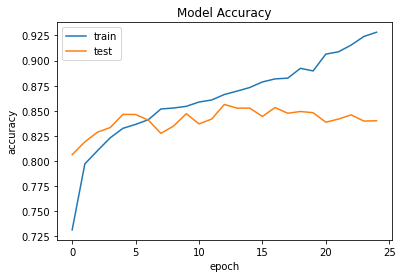

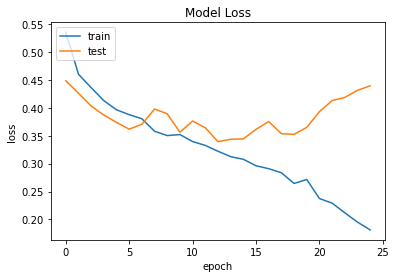

Train on 21000 samples, validate on 4500 samples
Epoch 1/25
21000/21000 [==============================] - 14s 689us/sample - loss: 0.5004 - accuracy: 0.7594 - val_loss: 0.4353 - val_accuracy: 0.7988
Epoch 2/25
21000/21000 [==============================] - 14s 650us/sample - loss: 0.4203 - accuracy: 0.8199 - val_loss: 0.3947 - val_accuracy: 0.8317
Epoch 3/25
21000/21000 [==============================] - 14s 650us/sample - loss: 0.4002 - accuracy: 0.8294 - val_loss: 0.3732 - val_accuracy: 0.8430
Epoch 4/25
21000/21000 [==============================] - 14s 650us/sample - loss: 0.3852 - accuracy: 0.8375 - val_loss: 0.3756 - val_accuracy: 0.8448
Epoch 5/25
21000/21000 [==============================] - 14s 650us/sample - loss: 0.3771 - accuracy: 0.8385 - val_loss: 0.3795 - val_accuracy: 0.8400
Epoch 6/25
21000/21000 [==============================] - 14s 650us/sample - loss: 0.3715 - accuracy: 0.8417 - val_loss: 0.3443 - val_accuracy: 0.8521
Epoch 7/25
21000/21000 [=====================

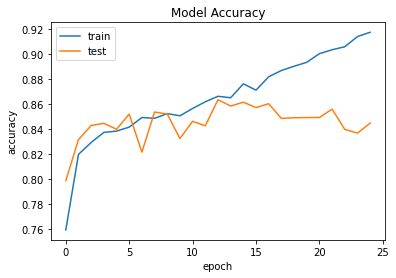

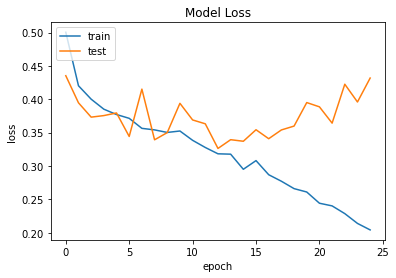

Train on 21000 samples, validate on 4500 samples
Epoch 1/25
21000/21000 [==============================] - 14s 677us/sample - loss: 0.5225 - accuracy: 0.7499 - val_loss: 0.4889 - val_accuracy: 0.7890
Epoch 2/25
21000/21000 [==============================] - 13s 633us/sample - loss: 0.4544 - accuracy: 0.8016 - val_loss: 0.4248 - val_accuracy: 0.8143
Epoch 3/25
21000/21000 [==============================] - 13s 630us/sample - loss: 0.4341 - accuracy: 0.8114 - val_loss: 0.4767 - val_accuracy: 0.7831
Epoch 4/25
21000/21000 [==============================] - 13s 628us/sample - loss: 0.4198 - accuracy: 0.8192 - val_loss: 0.4010 - val_accuracy: 0.8297
Epoch 5/25
21000/21000 [==============================] - 13s 624us/sample - loss: 0.3958 - accuracy: 0.8328 - val_loss: 0.3924 - val_accuracy: 0.8309
Epoch 6/25
21000/21000 [==============================] - 13s 628us/sample - loss: 0.3908 - accuracy: 0.8347 - val_loss: 0.3735 - val_accuracy: 0.8401
Epoch 7/25
21000/21000 [=====================

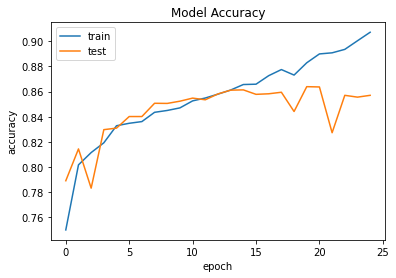

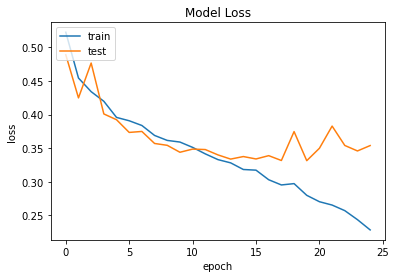

In [23]:
history_4 = train_evaluate_visualize(model_4)
history_5 = train_evaluate_visualize(model_5)
history_6 = train_evaluate_visualize(model_6)

Here all models start overfitting at about 10th-13th epoch.. The peak performance of all models over the validation data is at about 85% accuracy. It seems that <b>model_6</b> has the best performance as it accuracy on the testing data is 86,1%. Lets have a comparative look :

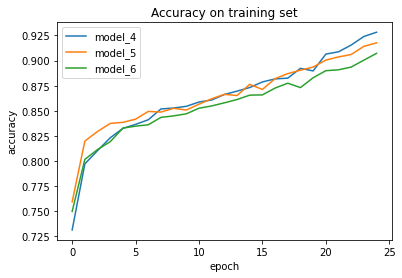

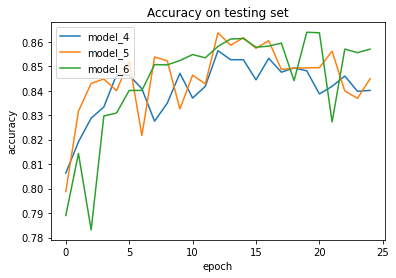

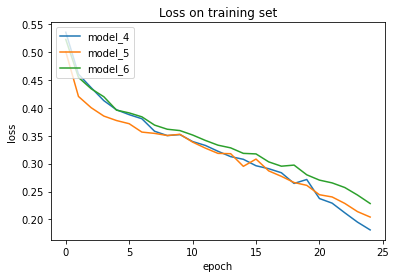

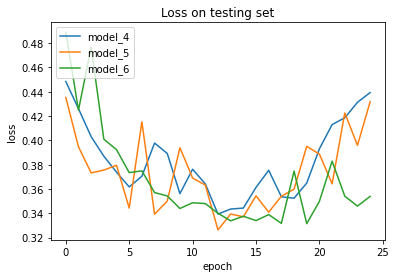

In [24]:
plot_model_performance( [history_4, history_5, history_6], [4, 5, 6] )

It seems that <b>model_6</b> has the best performance of this last triplet. Let compare it to the champion from the first triplet - <b>model_2</b>.

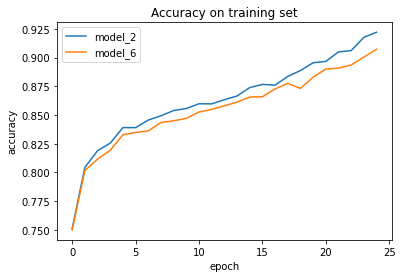

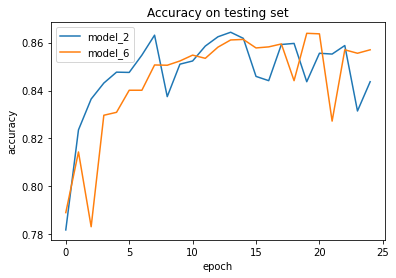

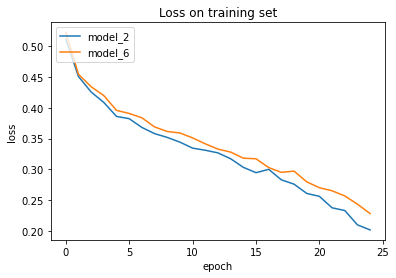

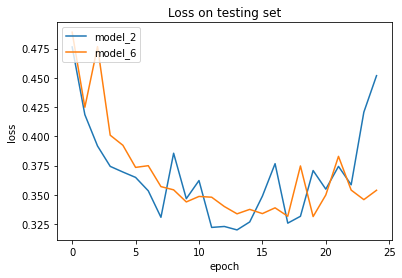

In [37]:
plot_model_performance( [history_2, history_6], [2, 6] )

<b>model_2</b>'s peak shows a bit higher results than <b>model_6</b>'s peak (epoch 13). Lets use them both in the next experiment.

### 4.2 Experiment 2 :  Tweak the number of kernels in convolutional layers

First lets see what will happen with less/more kernels in the convolutional layers. Suffixes 'L' and 'M' will be used respectively for more and less kernels per layer. The best performing models will get their dropout rates changed.

In [26]:
f = FILTERS//2 # base number of filters for this model
model_2_L = Sequential([
                        Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                        MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),

                        Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                        MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_2'),

                        Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                        MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),

                        Conv2D(filters=8*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_4'),
                        MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_4'),

                        Flatten(name='Flatten_layer'),

                        Dense(128, activation='relu', name='Dense_1'),
                        Dropout(0.2, name='Dropout_1'),

                        Dense(32, activation='relu', name='Dense_2'),
                        Dropout(0.1, name='Dropout_2'),

                        Dense(8, activation='relu', name='Dense_3'),

                        Dense(2, activation='sigmoid', name='Output_layer')
                        ])

model_2_L.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 4)         112       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 4)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 8)         296       
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 24, 24, 8)         0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 24, 24, 16)        1168      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 12, 12, 16)        0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 12, 12, 32)       

In [27]:
f = FILTERS*2 # base number of filters for this model
model_2_M = Sequential([
                        Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                        MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),

                        Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                        MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_2'),

                        Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                        MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),

                        Conv2D(filters=8*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_4'),
                        MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_4'),

                        Flatten(name='Flatten_layer'),

                        Dense(128, activation='relu', name='Dense_1'),
                        Dropout(0.2, name='Dropout_1'),

                        Dense(32, activation='relu', name='Dense_2'),
                        Dropout(0.1, name='Dropout_2'),

                        Dense(8, activation='relu', name='Dense_3'),

                        Dense(2, activation='sigmoid', name='Output_layer')
                        ])

model_2_M.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 16)        448       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 16)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 32)        4640      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 24, 24, 32)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 24, 24, 64)        18496     
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 12, 12, 64)        0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 12, 12, 128)      

Train on 21000 samples, validate on 4500 samples
Epoch 1/25
21000/21000 [==============================] - 12s 562us/sample - loss: 0.5487 - accuracy: 0.7046 - val_loss: 0.4457 - val_accuracy: 0.7954
Epoch 2/25
21000/21000 [==============================] - 10s 488us/sample - loss: 0.4384 - accuracy: 0.8086 - val_loss: 0.4275 - val_accuracy: 0.8106
Epoch 3/25
21000/21000 [==============================] - 10s 483us/sample - loss: 0.4176 - accuracy: 0.8174 - val_loss: 0.3977 - val_accuracy: 0.8274
Epoch 4/25
21000/21000 [==============================] - 10s 482us/sample - loss: 0.4047 - accuracy: 0.8231 - val_loss: 0.3905 - val_accuracy: 0.8313
Epoch 5/25
21000/21000 [==============================] - 10s 487us/sample - loss: 0.3974 - accuracy: 0.8293 - val_loss: 0.3796 - val_accuracy: 0.8431
Epoch 6/25
21000/21000 [==============================] - 10s 488us/sample - loss: 0.3946 - accuracy: 0.8307 - val_loss: 0.4694 - val_accuracy: 0.8138
Epoch 7/25
21000/21000 [=====================

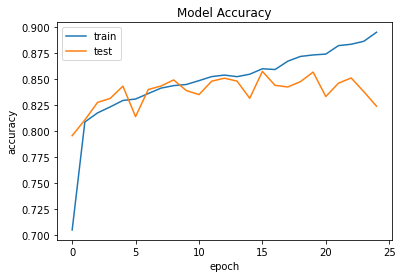

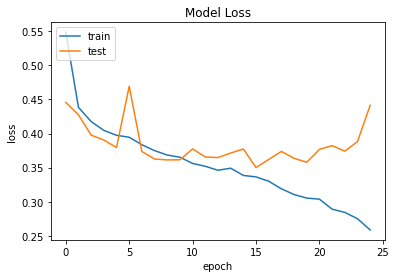

Train on 21000 samples, validate on 4500 samples
Epoch 1/25
21000/21000 [==============================] - 32s 2ms/sample - loss: 0.5069 - accuracy: 0.7514 - val_loss: 0.4342 - val_accuracy: 0.8070
Epoch 2/25
21000/21000 [==============================] - 30s 1ms/sample - loss: 0.4342 - accuracy: 0.8130 - val_loss: 0.3973 - val_accuracy: 0.8327
Epoch 3/25
21000/21000 [==============================] - 30s 1ms/sample - loss: 0.4141 - accuracy: 0.8243 - val_loss: 0.3746 - val_accuracy: 0.8403
Epoch 4/25
21000/21000 [==============================] - 30s 1ms/sample - loss: 0.3918 - accuracy: 0.8355 - val_loss: 0.3570 - val_accuracy: 0.8469
Epoch 5/25
21000/21000 [==============================] - 30s 1ms/sample - loss: 0.3758 - accuracy: 0.8417 - val_loss: 0.3462 - val_accuracy: 0.8519
Epoch 6/25
21000/21000 [==============================] - 29s 1ms/sample - loss: 0.3696 - accuracy: 0.8438 - val_loss: 0.3982 - val_accuracy: 0.8067
Epoch 7/25
21000/21000 [==============================] -

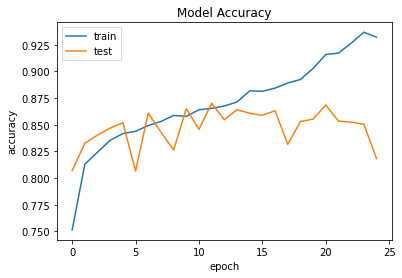

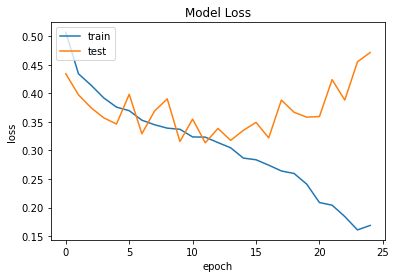

In [28]:
history_2_L = train_evaluate_visualize(model_2_L)
history_2_M = train_evaluate_visualize(model_2_M)

It seems that the more kernels a model has, the more it is overfitting. Lets have another comparative look :

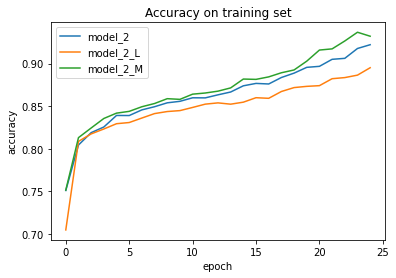

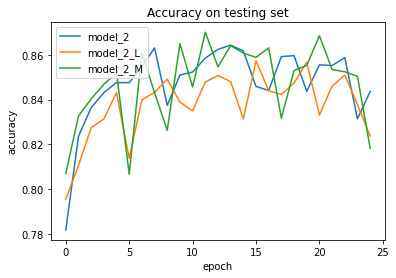

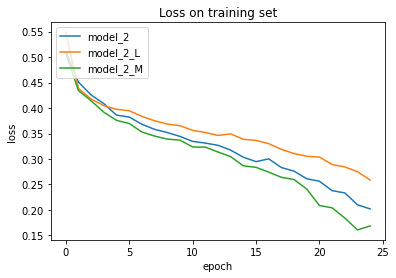

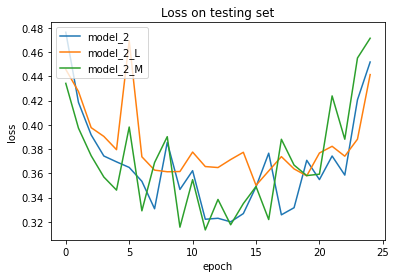

In [29]:
plot_model_performance( [history_2, history_2_L, history_2_M], [2, '2_L', '2_M'] )

<b>model_2</b> and <b>model_2_M</b> are similar in performance, but when we compare the results on the testing set <b>model_2</b> leads with just a few percent, standing at 84,5%. Lets use <b>model_2</b> for the next experiment.

Lets see what will happen with the 'offspring' of <b>model_6</b> :

In [33]:
f = FILTERS//2 # base number of filters for this model
model_6_L = Sequential([
                        Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                        MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),

                        Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                        MaxPooling2D(pool_size=(3, 3), strides=None, name='Pooling_2'),

                        Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                        MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),

                        Flatten(name='Flatten_layer'),

                        Dense(128, activation='relu', name='Dense_1'),
                        Dropout(0.2, name='Dropout_1'),

                        Dense(32, activation='relu', name='Dense_2'),
                        Dropout(0.1, name='Dropout_2'),

                        Dense(8, activation='relu', name='Dense_3'),

                        Dense(2, activation='sigmoid', name='Output_layer')
                        ])

model_6_L.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 4)         112       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 4)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 8)         296       
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 16, 16, 8)         0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 16, 16, 16)        1168      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 8, 8, 16)          0         
_________________________________________________________________
Flatten_layer (Flatten)      (None, 1024)            

In [34]:
f = FILTERS*2 # base number of filters for this model
model_6_M = Sequential([
                        Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                        MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),

                        Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                        MaxPooling2D(pool_size=(3, 3), strides=None, name='Pooling_2'),

                        Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                        MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),

                        Flatten(name='Flatten_layer'),

                        Dense(128, activation='relu', name='Dense_1'),
                        Dropout(0.2, name='Dropout_1'),

                        Dense(32, activation='relu', name='Dense_2'),
                        Dropout(0.1, name='Dropout_2'),

                        Dense(8, activation='relu', name='Dense_3'),

                        Dense(2, activation='sigmoid', name='Output_layer')
                        ])

model_6_M.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 16)        448       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 16)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 32)        4640      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 16, 16, 64)        18496     
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 8, 8, 64)          0         
_________________________________________________________________
Flatten_layer (Flatten)      (None, 4096)            

Train on 21000 samples, validate on 4500 samples
Epoch 1/25
21000/21000 [==============================] - 9s 449us/sample - loss: 0.5305 - accuracy: 0.7413 - val_loss: 0.4638 - val_accuracy: 0.7993
Epoch 2/25
21000/21000 [==============================] - 9s 410us/sample - loss: 0.4548 - accuracy: 0.8021 - val_loss: 0.4898 - val_accuracy: 0.7804
Epoch 3/25
21000/21000 [==============================] - 9s 407us/sample - loss: 0.4262 - accuracy: 0.8164 - val_loss: 0.4149 - val_accuracy: 0.8199
Epoch 4/25
21000/21000 [==============================] - 9s 409us/sample - loss: 0.4181 - accuracy: 0.8196 - val_loss: 0.3924 - val_accuracy: 0.8373
Epoch 5/25
21000/21000 [==============================] - 9s 410us/sample - loss: 0.4026 - accuracy: 0.8275 - val_loss: 0.3828 - val_accuracy: 0.8397
Epoch 6/25
21000/21000 [==============================] - 9s 409us/sample - loss: 0.3943 - accuracy: 0.8337 - val_loss: 0.3724 - val_accuracy: 0.8503
Epoch 7/25
21000/21000 [===========================

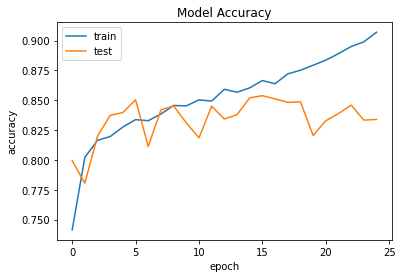

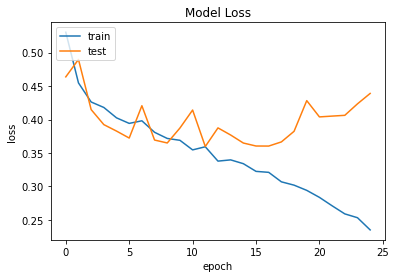

Train on 21000 samples, validate on 4500 samples
Epoch 1/25
21000/21000 [==============================] - 23s 1ms/sample - loss: 0.5166 - accuracy: 0.7505 - val_loss: 0.4361 - val_accuracy: 0.8113
Epoch 2/25
21000/21000 [==============================] - 22s 1ms/sample - loss: 0.4361 - accuracy: 0.8110 - val_loss: 0.4671 - val_accuracy: 0.7761
Epoch 3/25
21000/21000 [==============================] - 22s 1ms/sample - loss: 0.4173 - accuracy: 0.8202 - val_loss: 0.4049 - val_accuracy: 0.8148
Epoch 4/25
21000/21000 [==============================] - 22s 1ms/sample - loss: 0.3996 - accuracy: 0.8310 - val_loss: 0.3865 - val_accuracy: 0.8360
Epoch 5/25
21000/21000 [==============================] - 22s 1ms/sample - loss: 0.3886 - accuracy: 0.8351 - val_loss: 0.4870 - val_accuracy: 0.7800
Epoch 6/25
21000/21000 [==============================] - 22s 1ms/sample - loss: 0.3777 - accuracy: 0.8394 - val_loss: 0.3657 - val_accuracy: 0.8417
Epoch 7/25
21000/21000 [==============================] -

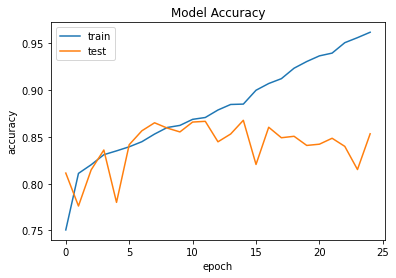

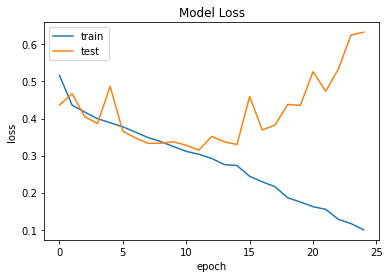

In [35]:
history_6_L = train_evaluate_visualize(model_6_L)
history_6_M = train_evaluate_visualize(model_6_M)

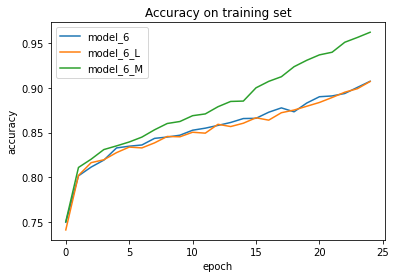

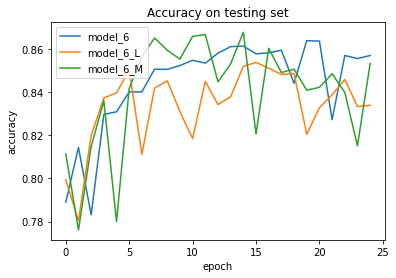

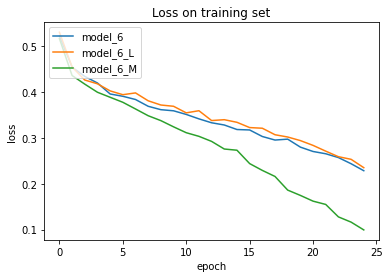

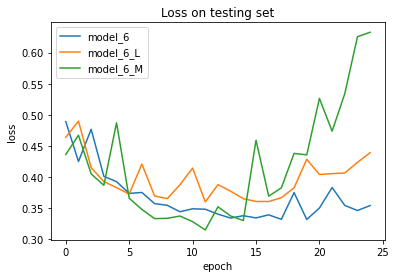

In [36]:
plot_model_performance( [history_6, history_6_L, history_6_M], [6, '6_L', '6_M'] )

Even though <b>model_6_M</b> shows a bit better performaner than <b>model_6</b> halfway through the training, it is quite volatile and does not bring higher accuracy on the testing set.

For the next part of the experiment <b>model_2</b> and <b>model_6</b> will be used. 

### 4.3 Experiment 3 :  Increase / decrease dropout rate

Suffixes 'D' (droupout decreased) and 'I' (droupout increased) will be used to match the experiment.

In [42]:
f = FILTERS # base number of filters for this model
model_2_D = Sequential([
                    Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                    MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),
    
                    Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_2'),
    
                    Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),
    
                    Conv2D(filters=8*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_4'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_4'),
                    
                    Flatten(name='Flatten_layer'),
    
                    Dense(128, activation='relu', name='Dense_1'),
                    Dropout(0.10, name='Dropout_1'),

                    Dense(32, activation='relu', name='Dense_2'),
                    Dropout(0.05, name='Dropout_2'),

                    Dense(8, activation='relu', name='Dense_3'),

                    Dense(2, activation='sigmoid', name='Output_layer')
                    ])

model_2_D.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 8)         224       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 8)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 16)        1168      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 24, 24, 16)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 24, 24, 32)        4640      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 12, 12, 32)        0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 12, 12, 64)      

In [43]:
f = FILTERS # base number of filters for this model
model_2_I = Sequential([
                    Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                    MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),
    
                    Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_2'),
    
                    Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),
    
                    Conv2D(filters=8*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_4'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_4'),
                    
                    Flatten(name='Flatten_layer'),
    
                    Dense(128, activation='relu', name='Dense_1'),
                    Dropout(0.3, name='Dropout_1'),

                    Dense(32, activation='relu', name='Dense_2'),
                    Dropout(0.15, name='Dropout_2'),

                    Dense(8, activation='relu', name='Dense_3'),

                    Dense(2, activation='sigmoid', name='Output_layer')
                    ])

model_2_I.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 8)         224       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 8)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 16)        1168      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 24, 24, 16)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 24, 24, 32)        4640      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 12, 12, 32)        0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 12, 12, 64)      

Train on 21000 samples, validate on 4500 samples
Epoch 1/25
21000/21000 [==============================] - 17s 825us/sample - loss: 0.5166 - accuracy: 0.7430 - val_loss: 0.4238 - val_accuracy: 0.8137
Epoch 2/25
21000/21000 [==============================] - 17s 786us/sample - loss: 0.4303 - accuracy: 0.8130 - val_loss: 0.4123 - val_accuracy: 0.8180
Epoch 3/25
21000/21000 [==============================] - 16s 782us/sample - loss: 0.4228 - accuracy: 0.8185 - val_loss: 0.4185 - val_accuracy: 0.8298
Epoch 4/25
21000/21000 [==============================] - 17s 786us/sample - loss: 0.4191 - accuracy: 0.8203 - val_loss: 0.4036 - val_accuracy: 0.8343
Epoch 5/25
21000/21000 [==============================] - 17s 789us/sample - loss: 0.4019 - accuracy: 0.8298 - val_loss: 0.4905 - val_accuracy: 0.7870
Epoch 6/25
21000/21000 [==============================] - 16s 781us/sample - loss: 0.3943 - accuracy: 0.8330 - val_loss: 0.3715 - val_accuracy: 0.8412
Epoch 7/25
21000/21000 [=====================

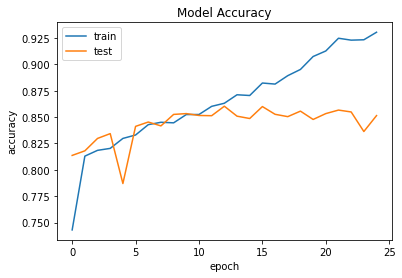

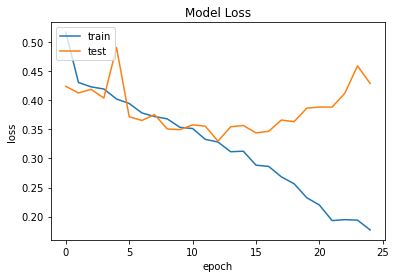

Train on 21000 samples, validate on 4500 samples
Epoch 1/25
21000/21000 [==============================] - 18s 836us/sample - loss: 0.5169 - accuracy: 0.7556 - val_loss: 0.4309 - val_accuracy: 0.8076
Epoch 2/25
21000/21000 [==============================] - 16s 785us/sample - loss: 0.4421 - accuracy: 0.8091 - val_loss: 0.4052 - val_accuracy: 0.8269
Epoch 3/25
21000/21000 [==============================] - 16s 784us/sample - loss: 0.4225 - accuracy: 0.8183 - val_loss: 0.3956 - val_accuracy: 0.8303
Epoch 4/25
21000/21000 [==============================] - 16s 780us/sample - loss: 0.4152 - accuracy: 0.8220 - val_loss: 0.3926 - val_accuracy: 0.8331
Epoch 5/25
21000/21000 [==============================] - 16s 781us/sample - loss: 0.4030 - accuracy: 0.8277 - val_loss: 0.3772 - val_accuracy: 0.8393
Epoch 6/25
21000/21000 [==============================] - 16s 781us/sample - loss: 0.3920 - accuracy: 0.8316 - val_loss: 0.3715 - val_accuracy: 0.8417
Epoch 7/25
21000/21000 [=====================

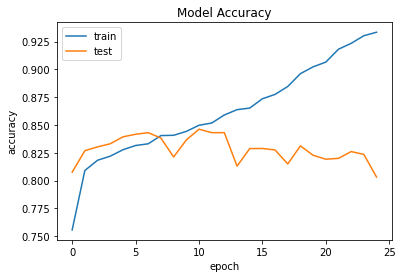

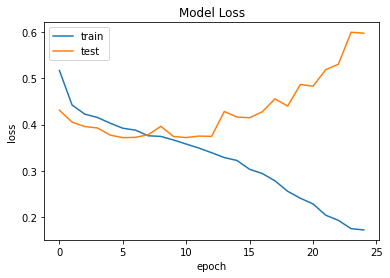

In [44]:
history_2_D = train_evaluate_visualize(model_2_D)
history_2_I = train_evaluate_visualize(model_2_I)

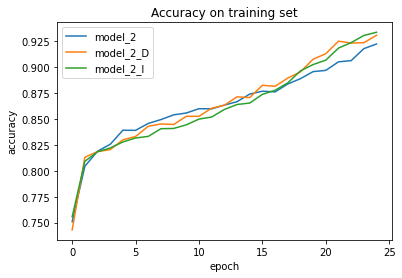

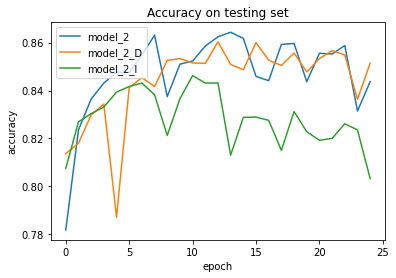

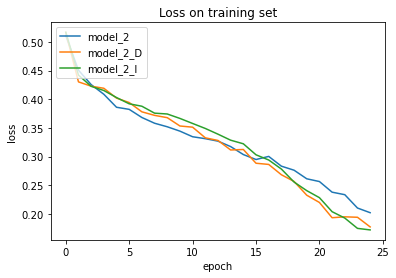

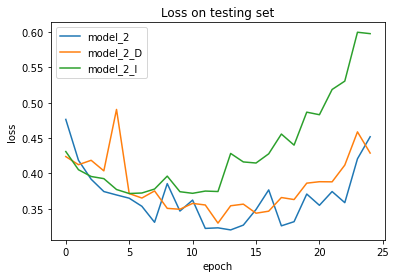

In [45]:
plot_model_performance( [history_2, history_2_D, history_2_I], [2, '2_D', '2_I'] )

It seems that the initial amount of droupout performs the best and <b>model_2</b> is still victorious.

Lets take a look at the group of <b>model_6</b> and its variations :

In [46]:
f = FILTERS # base number of filters for this model
model_6_D = Sequential([
                    Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                    MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),
    
                    Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                    MaxPooling2D(pool_size=(3, 3), strides=None, name='Pooling_2'),
    
                    Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),
                    
                    Flatten(name='Flatten_layer'),
    
                    Dense(128, activation='relu', name='Dense_1'),
                    Dropout(0.1, name='Dropout_1'),

                    Dense(32, activation='relu', name='Dense_2'),
                    Dropout(0.05, name='Dropout_2'),

                    Dense(8, activation='relu', name='Dense_3'),

                    Dense(2, activation='sigmoid', name='Output_layer')
                    ])

model_6_D.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 8)         224       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 8)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 16)        1168      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 16, 16, 16)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 16, 16, 32)        4640      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 8, 8, 32)          0         
_________________________________________________________________
Flatten_layer (Flatten)      (None, 2048)            

In [47]:
f = FILTERS # base number of filters for this model
model_6_I = Sequential([
                    Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                    MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),
    
                    Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                    MaxPooling2D(pool_size=(3, 3), strides=None, name='Pooling_2'),
    
                    Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),
                    
                    Flatten(name='Flatten_layer'),
    
                    Dense(128, activation='relu', name='Dense_1'),
                    Dropout(0.30, name='Dropout_1'),

                    Dense(32, activation='relu', name='Dense_2'),
                    Dropout(0.15, name='Dropout_2'),

                    Dense(8, activation='relu', name='Dense_3'),

                    Dense(2, activation='sigmoid', name='Output_layer')
                    ])

model_6_I.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 8)         224       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 8)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 16)        1168      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 16, 16, 16)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 16, 16, 32)        4640      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 8, 8, 32)          0         
_________________________________________________________________
Flatten_layer (Flatten)      (None, 2048)            

Train on 21000 samples, validate on 4500 samples
Epoch 1/25
21000/21000 [==============================] - 14s 671us/sample - loss: 0.5219 - accuracy: 0.7416 - val_loss: 0.4474 - val_accuracy: 0.7903
Epoch 2/25
21000/21000 [==============================] - 13s 624us/sample - loss: 0.4414 - accuracy: 0.8051 - val_loss: 0.4164 - val_accuracy: 0.8159
Epoch 3/25
21000/21000 [==============================] - 13s 621us/sample - loss: 0.4163 - accuracy: 0.8173 - val_loss: 0.4103 - val_accuracy: 0.8214
Epoch 4/25
21000/21000 [==============================] - 13s 624us/sample - loss: 0.3953 - accuracy: 0.8288 - val_loss: 0.3795 - val_accuracy: 0.8377
Epoch 5/25
21000/21000 [==============================] - 13s 623us/sample - loss: 0.3857 - accuracy: 0.8345 - val_loss: 0.4033 - val_accuracy: 0.8224
Epoch 6/25
21000/21000 [==============================] - 13s 629us/sample - loss: 0.3884 - accuracy: 0.8328 - val_loss: 0.3822 - val_accuracy: 0.8422
Epoch 7/25
21000/21000 [=====================

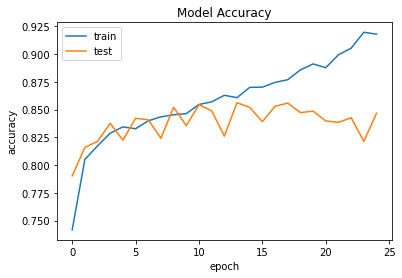

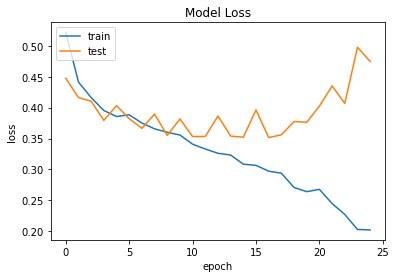

Train on 21000 samples, validate on 4500 samples
Epoch 1/25
21000/21000 [==============================] - 14s 659us/sample - loss: 0.5325 - accuracy: 0.7451 - val_loss: 0.4344 - val_accuracy: 0.8102
Epoch 2/25
21000/21000 [==============================] - 13s 620us/sample - loss: 0.4442 - accuracy: 0.8042 - val_loss: 0.4085 - val_accuracy: 0.8243
Epoch 3/25
21000/21000 [==============================] - 13s 624us/sample - loss: 0.4262 - accuracy: 0.8149 - val_loss: 0.4028 - val_accuracy: 0.8262
Epoch 4/25
21000/21000 [==============================] - 13s 625us/sample - loss: 0.4121 - accuracy: 0.8199 - val_loss: 0.3805 - val_accuracy: 0.8374
Epoch 5/25
21000/21000 [==============================] - 13s 621us/sample - loss: 0.3937 - accuracy: 0.8306 - val_loss: 0.4069 - val_accuracy: 0.8224
Epoch 6/25
21000/21000 [==============================] - 13s 620us/sample - loss: 0.3857 - accuracy: 0.8369 - val_loss: 0.3878 - val_accuracy: 0.8350
Epoch 7/25
21000/21000 [=====================

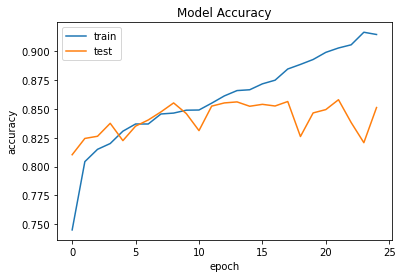

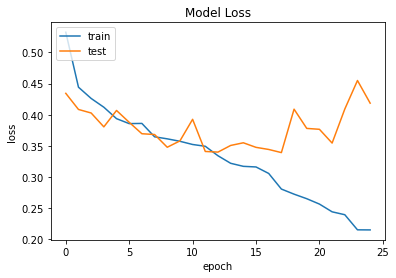

In [48]:
history_6_D = train_evaluate_visualize(model_6_D)
history_6_I = train_evaluate_visualize(model_6_I)

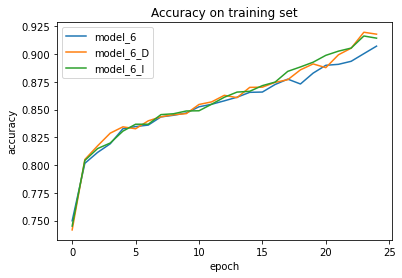

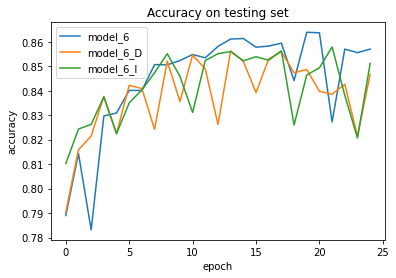

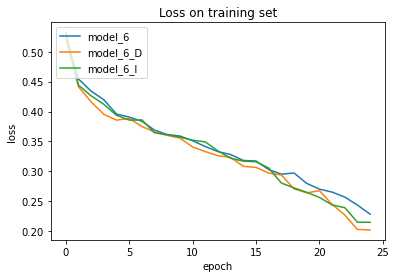

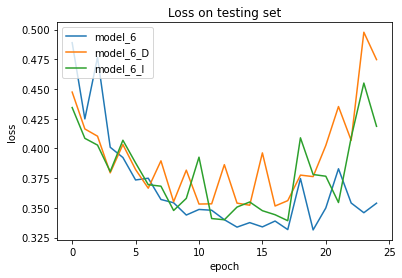

In [49]:
plot_model_performance( [history_6, model_6_D, model_6_I], [6, '6_D', '6_I'] )

It seems that <b>model_6</b> is the best performer from this subset.

Lets have a quick reminding look at the behaviour of <b>model_2</b> and <b>model_6</b> :

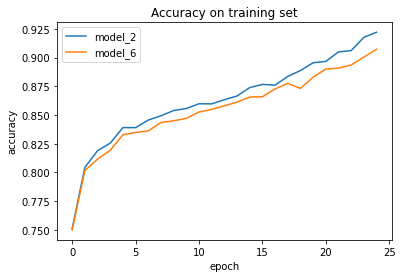

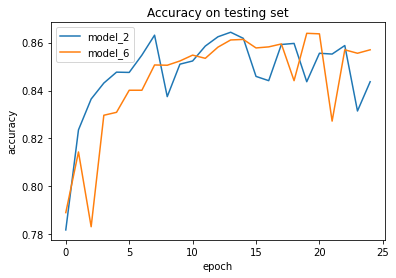

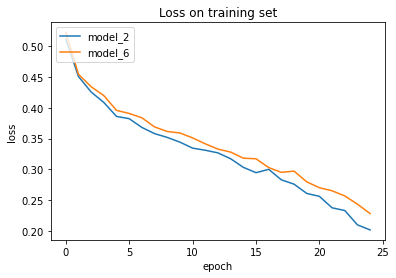

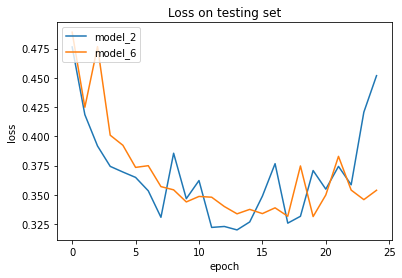

In [50]:
plot_model_performance( [history_2, history_6], [2, 6] )

Clearly <b>model_2</b> is a bit better. Lets retrain it with a stronger learning rate decay and save the weights from the best performance.

### 4.3 Experiment 4: Increase / decrease the learning rate or decay of the best model

Since the learning rate has been showing good results from the start lets keep it and tweak the rate of decay. Up to now it was set on 98%. Lets try a 95% and see if additional change is required.

In [51]:
f = FILTERS # base number of filters for this model
model = Sequential([
                    Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                    MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),
    
                    Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_2'),
    
                    Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),
    
                    Conv2D(filters=8*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_4'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_4'),
                    
                    Flatten(name='Flatten_layer'),
    
                    Dense(128, activation='relu', name='Dense_1'),
                    Dropout(0.2, name='Dropout_1'),

                    Dense(32, activation='relu', name='Dense_2'),
                    Dropout(0.1, name='Dropout_2'),

                    Dense(8, activation='relu', name='Dense_3'),

                    Dense(2, activation='sigmoid', name='Output_layer')
                    ])

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 8)         224       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 8)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 16)        1168      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 24, 24, 16)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 24, 24, 32)        4640      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 12, 12, 32)        0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 12, 12, 64)      

Train on 21000 samples, validate on 4500 samples
Epoch 1/30
21000/21000 [==============================] - 18s 835us/sample - loss: 0.4216 - accuracy: 0.8187 - val_loss: 0.3883 - val_accuracy: 0.8352
Epoch 2/30
21000/21000 [==============================] - 16s 782us/sample - loss: 0.4002 - accuracy: 0.8299 - val_loss: 0.3775 - val_accuracy: 0.8424
Epoch 3/30
21000/21000 [==============================] - 16s 782us/sample - loss: 0.3892 - accuracy: 0.8350 - val_loss: 0.3661 - val_accuracy: 0.8407
Epoch 4/30
21000/21000 [==============================] - 16s 783us/sample - loss: 0.3762 - accuracy: 0.8402 - val_loss: 0.3853 - val_accuracy: 0.8363
Epoch 5/30
21000/21000 [==============================] - 16s 783us/sample - loss: 0.3654 - accuracy: 0.8452 - val_loss: 0.3605 - val_accuracy: 0.8469
Epoch 6/30
21000/21000 [==============================] - 16s 783us/sample - loss: 0.3620 - accuracy: 0.8474 - val_loss: 0.3491 - val_accuracy: 0.8489
Epoch 7/30
21000/21000 [=====================

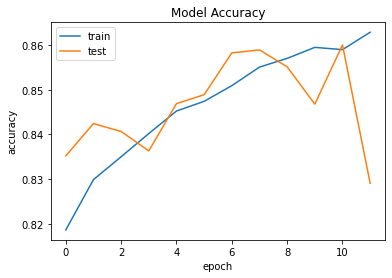

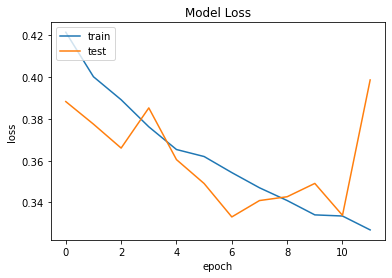

In [53]:
history = train_evaluate_visualize(model, epochs=30, batch_size=100, initial_learning_rate=0.001, dacay_rate=0.95, use_early_stopping=True)

Lets retrain model with 99% to see if anything better will come out :

In [54]:
f = FILTERS # base number of filters for this model
Model = Sequential([
                    Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                    MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),
    
                    Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_2'),
    
                    Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),
    
                    Conv2D(filters=8*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_4'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_4'),
                    
                    Flatten(name='Flatten_layer'),
    
                    Dense(128, activation='relu', name='Dense_1'),
                    Dropout(0.2, name='Dropout_1'),

                    Dense(32, activation='relu', name='Dense_2'),
                    Dropout(0.1, name='Dropout_2'),

                    Dense(8, activation='relu', name='Dense_3'),

                    Dense(2, activation='sigmoid', name='Output_layer')
                    ])

Model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 8)         224       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 8)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 16)        1168      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 24, 24, 16)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 24, 24, 32)        4640      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 12, 12, 32)        0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 12, 12, 64)      

Train on 21000 samples, validate on 4500 samples
Epoch 1/30
21000/21000 [==============================] - 18s 838us/sample - loss: 0.5367 - accuracy: 0.7264 - val_loss: 0.4337 - val_accuracy: 0.8258
Epoch 2/30
21000/21000 [==============================] - 16s 781us/sample - loss: 0.4250 - accuracy: 0.8188 - val_loss: 0.3892 - val_accuracy: 0.8332
Epoch 3/30
21000/21000 [==============================] - 16s 782us/sample - loss: 0.3989 - accuracy: 0.8289 - val_loss: 0.4031 - val_accuracy: 0.8363
Epoch 4/30
21000/21000 [==============================] - 16s 784us/sample - loss: 0.3919 - accuracy: 0.8321 - val_loss: 0.3766 - val_accuracy: 0.8342
Epoch 5/30
21000/21000 [==============================] - 16s 781us/sample - loss: 0.3823 - accuracy: 0.8346 - val_loss: 0.3626 - val_accuracy: 0.8477
Epoch 6/30
21000/21000 [==============================] - 16s 784us/sample - loss: 0.3818 - accuracy: 0.8373 - val_loss: 0.3697 - val_accuracy: 0.8438
Epoch 7/30
21000/21000 [=====================

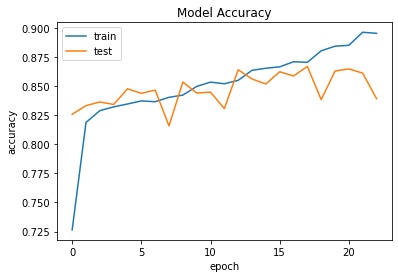

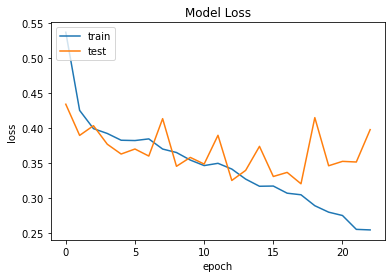

In [56]:
history = train_evaluate_visualize(Model, epochs=30, batch_size=100, initial_learning_rate=0.001, dacay_rate=0.99, use_early_stopping=True)

Lets retrain model with 100% = without decay to see if anything better will come out :

In [57]:
f = FILTERS # base number of filters for this model
MODEL = Sequential([
                    Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                    MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),
    
                    Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_2'),
    
                    Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),
    
                    Conv2D(filters=8*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_4'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_4'),
                    
                    Flatten(name='Flatten_layer'),
    
                    Dense(128, activation='relu', name='Dense_1'),
                    Dropout(0.2, name='Dropout_1'),

                    Dense(32, activation='relu', name='Dense_2'),
                    Dropout(0.1, name='Dropout_2'),

                    Dense(8, activation='relu', name='Dense_3'),

                    Dense(2, activation='sigmoid', name='Output_layer')
                    ])

MODEL.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 8)         224       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 8)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 16)        1168      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 24, 24, 16)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 24, 24, 32)        4640      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 12, 12, 32)        0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 12, 12, 64)      

Train on 21000 samples, validate on 4500 samples
Epoch 1/30
21000/21000 [==============================] - 18s 850us/sample - loss: 0.5207 - accuracy: 0.7427 - val_loss: 0.4430 - val_accuracy: 0.8027
Epoch 2/30
21000/21000 [==============================] - 17s 813us/sample - loss: 0.4338 - accuracy: 0.8122 - val_loss: 0.3973 - val_accuracy: 0.8328
Epoch 3/30
21000/21000 [==============================] - 17s 796us/sample - loss: 0.4047 - accuracy: 0.8287 - val_loss: 0.4072 - val_accuracy: 0.8314
Epoch 4/30
21000/21000 [==============================] - 17s 791us/sample - loss: 0.4010 - accuracy: 0.8292 - val_loss: 0.3689 - val_accuracy: 0.8436
Epoch 5/30
21000/21000 [==============================] - 16s 782us/sample - loss: 0.3816 - accuracy: 0.8399 - val_loss: 0.3588 - val_accuracy: 0.8466
Epoch 6/30
21000/21000 [==============================] - 16s 782us/sample - loss: 0.3792 - accuracy: 0.8407 - val_loss: 0.3614 - val_accuracy: 0.8452
Epoch 7/30
21000/21000 [=====================

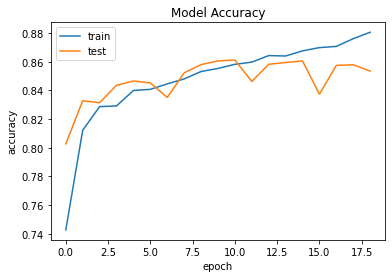

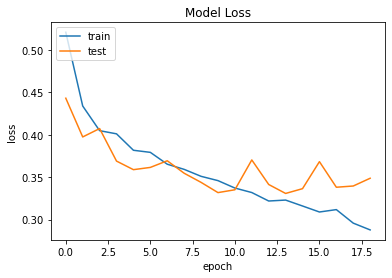

In [58]:
history = train_evaluate_visualize(MODEL, epochs=30, batch_size=100, initial_learning_rate=0.001, dacay_rate=1, use_early_stopping=True)

To get the accuracy of <b>model_2</b> on the testing set, a new training is in order :

In [59]:
f = FILTERS # base number of filters for this model
model_2 = Sequential([
                    Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 3), name='Conv_1'),
                    MaxPooling2D(pool_size=(3, 3), strides=1, name='Pooling_1'),
    
                    Conv2D(filters=2*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_2'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_2'),
    
                    Conv2D(filters=4*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_3'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_3'),
    
                    Conv2D(filters=8*f, kernel_size=(3, 3), padding='same', activation='relu', name='Conv_4'),
                    MaxPooling2D(pool_size=(2, 2), strides=None, name='Pooling_4'),
                    
                    Flatten(name='Flatten_layer'),
    
                    Dense(128, activation='relu', name='Dense_1'),
                    Dropout(0.2, name='Dropout_1'),

                    Dense(32, activation='relu', name='Dense_2'),
                    Dropout(0.1, name='Dropout_2'),

                    Dense(8, activation='relu', name='Dense_3'),

                    Dense(2, activation='sigmoid', name='Output_layer')
                    ])

model_2.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 50, 50, 8)         224       
_________________________________________________________________
Pooling_1 (MaxPooling2D)     (None, 48, 48, 8)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 48, 48, 16)        1168      
_________________________________________________________________
Pooling_2 (MaxPooling2D)     (None, 24, 24, 16)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 24, 24, 32)        4640      
_________________________________________________________________
Pooling_3 (MaxPooling2D)     (None, 12, 12, 32)        0         
_________________________________________________________________
Conv_4 (Conv2D)              (None, 12, 12, 64)      

Train on 21000 samples, validate on 4500 samples
Epoch 1/30
21000/21000 [==============================] - 18s 862us/sample - loss: 0.4774 - accuracy: 0.7820 - val_loss: 0.4228 - val_accuracy: 0.8184
Epoch 2/30
21000/21000 [==============================] - 17s 788us/sample - loss: 0.4250 - accuracy: 0.8176 - val_loss: 0.4172 - val_accuracy: 0.8113
Epoch 3/30
21000/21000 [==============================] - 16s 781us/sample - loss: 0.4129 - accuracy: 0.8220 - val_loss: 0.3836 - val_accuracy: 0.8366
Epoch 4/30
21000/21000 [==============================] - 17s 792us/sample - loss: 0.3898 - accuracy: 0.8362 - val_loss: 0.3825 - val_accuracy: 0.8363
Epoch 5/30
21000/21000 [==============================] - 16s 783us/sample - loss: 0.3728 - accuracy: 0.8414 - val_loss: 0.3566 - val_accuracy: 0.8440
Epoch 6/30
21000/21000 [==============================] - 16s 783us/sample - loss: 0.3686 - accuracy: 0.8433 - val_loss: 0.3531 - val_accuracy: 0.8472
Epoch 7/30
21000/21000 [=====================

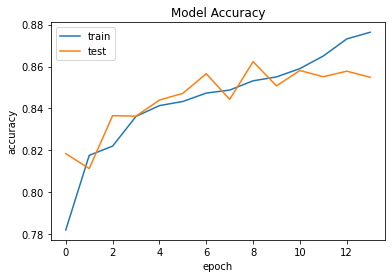

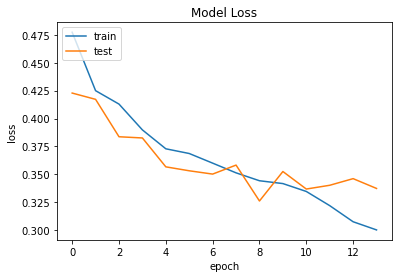

In [60]:
history = train_evaluate_visualize(model_2, epochs=30, batch_size=100, initial_learning_rate=0.001, dacay_rate=0.98, use_early_stopping=True)

## 5. Final analysis

Considering early stopping on best loss on validation data, the results are:

<b>model</b>   (95%) : Epoch 18/30 - training accuracy: 0.8509 | validation accuracy: 0.8582 | testing accuracy:  0.8544

<b>model_2</b> (98%) : Epoch 09/25 - training accuracy: 0.8532 | validation accuracy: 0.8623 | testing accuracy:  0.8569

<b>Model</b>   (99%) : Epoch 18/30 - training accuracy: 0.8704 | validation accuracy: 0.8669 | testing accuracy:  0.8672

<b>MODEL</b>  (100%) : Epoch 14/30 - training accuracy: 0.8640 | validation accuracy: 0.8594 | testing accuracy:  0.8569

<b>Even though the results are pretty close, it seems that <u><i>Model</i></u> is the best performer!</b>

Lets see the results of <b>Model</b> in a confusion matrix.

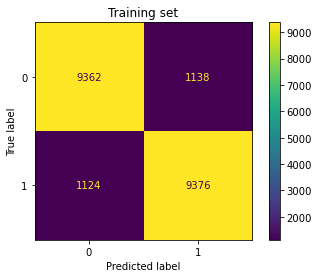

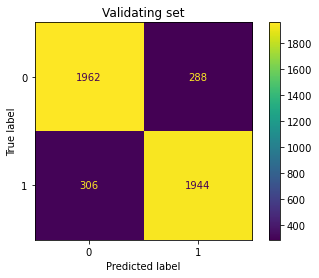

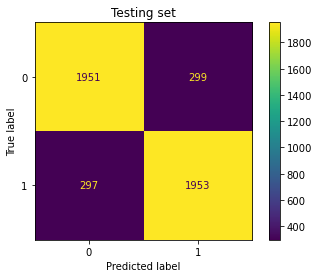

In [79]:
predict_train = Model.predict(train_data)
predict_val   = Model.predict(val_data)
predict_test  = Model.predict(test_data)

def convert_to_single_label(one_hot_labels):
    return np.argmax(one_hot_labels, axis=1)

# Convert training, validating and testing labels
true_train_labels = convert_to_single_label(train_labels)
true_val_labels   = convert_to_single_label(val_labels)
true_test_labels  = convert_to_single_label(test_labels)

# Convert the predicted labels
predict_training   = convert_to_single_label(predict_train)
predict_validating = convert_to_single_label(predict_val)
predict_testing    = convert_to_single_label(predict_test)

# Calculate and show confusion matrix
def show_confusion_matrix(true_label, predicted_label, title):
    cm = confusion_matrix(true_label, predicted_label)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()

show_confusion_matrix( true_train_labels, predict_training,   'Training set'   )
show_confusion_matrix( true_val_labels,   predict_validating, 'Validating set' )
show_confusion_matrix( true_test_labels,  predict_testing,    'Testing set'    )